In [90]:
import os
import pandas as pd
import numpy as np
import csv
import time
import gensim
from gensim.models.word2vec import Word2Vec  #构建词向量模型
from gensim import corpora,models
from sklearn.cluster import KMeans  #聚类
import matplotlib.pyplot as plt  #数据可视化
from sklearn.manifold import TSNE  #给数据降维
import json


In [91]:
path_dir = 'E:\\PycharmProjects\\Demo0410\\work_data_liziqi\\data'
excel_file = 'shenghuo_comments_32741.xlsx'
path_file = os.path.join(path_dir,excel_file)

In [92]:
#读取excel表格里的内容，并将要处理的数据转换为list of list。
comments_df = pd.read_excel(path_file,index_col=0)
cut_word_list = [line.split() for line in comments_df['cut_word'] ]  #将comments_df['cut_word']里的内容变成list of list，line.split()即把字符串分割后变成列表。

In [93]:
#生成文档对应的词典和稀疏向量。
dictionary = corpora.Dictionary(cut_word_list)  #生成只包含唯一词的词典（即词典内包含要处理的数据中所有去重后的词）。
corpus = [dictionary.doc2bow(text) for text in cut_word_list]  #建立每个词的稀疏向量。
#建立tf-idf模型并对所需文档计算ft-idf结果。
tfidf_model = models.TfidfModel(corpus)  #对每个词进行tf-idf建模。
corpus_tfidf = tfidf_model[corpus]  #计算文档中每个词的tf-idf权重。

In [94]:
id_list = []
for line in cut_word_list:
    id = []
    for word in line:
        id.append(dictionary.token2id[word])
    id_list.append(id)

In [95]:
#下面的比较复杂，要认真看。经过人工反复比对验证，下面的代码没有任何问题。可直接用。
def sort_word_tfidf_accord_with_id_list(corpus_tfidf,id_list):
    word_tfidf = []
    i = 0
    while i < len(corpus_tfidf):
        vec = []
        for id in id_list[i]:  #取出id列表里的每一行。
            j = 0  #这里j主要表示循环到第j条line_tfidf，则取此line_tfidf中第j个元素。
            for line_tfidf in corpus_tfidf[i]:  #corpus_tfidf[i]本来就是一行，这里的循环是找一行中的单个元素。
                if id == line_tfidf[0]:
                    tfidf = corpus_tfidf[i][j][1]   #这里i代表corpus_tfidf这个list of list中的第i个list(即一行)，j代表第i个list中的第j个元素，数字1即这第j个元素中的第2个子元素（第1个子元素用0表示）。
                j += 1
            vec.append(tfidf)
        word_tfidf.append(vec)
        i += 1
    return word_tfidf  #输出的word_tfidf为一个包含各行各单词权重的list of list。
#完成此步骤后，word_vec中的各权重即可与cut_word_list中的各词相对应。以下代码可验证。

word_tfidf = sort_word_tfidf_accord_with_id_list(corpus_tfidf,id_list)

#以下为验证以上步骤的代码。
'''
print(word_tfidf[32665])
print(id_list[32665])
print(cut_word_list[32665])
print(corpus_tfidf[32665])
'''

'\nprint(word_tfidf[32665])\nprint(id_list[32665])\nprint(cut_word_list[32665])\nprint(corpus_tfidf[32665])\n'

In [96]:
word_tfidf_narray = []
for line in word_tfidf:
    line_array = np.array(line,dtype = np.float32)
    word_tfidf_narray.append(line_array)

In [100]:
'''
n_dim = 100  #word2vec词向量的维度。经试验100维最合适。
model = Word2Vec(vector_size=n_dim, window=5, workers=10, min_count=1)  #创建向量模型实例。经实验window=5最合适。
model.build_vocab(cut_word_list)  #生成词表，注意这里的comment_filtered_dataframe.cut必须为list of list，否则会出错。
%time model.train(cut_word_list,total_examples=model.corpus_count,epochs=10)  #在评论集上建模。经试验，迭代10次是效果是最好的。
#model.save(path_dir + '\\' + 'shenghuo_word_vec.mod') #保存模型。2021年5月13日 22:34分保存的模型较完美，下次可以不用训练，直接用。
'''
model = Word2Vec.load('E:\PycharmProjects\Demo0410\work_data_liziqi\data\shenghuo_word_vec.mod') #加载此前训练好的模型。


Wall time: 1.02 s


In [103]:
model.wv.similar_by_word('美好生活')

[('人与自然', 0.8701077699661255),
 ('美好事物', 0.8543921709060669),
 ('乡土气息', 0.8523790836334229),
 ('生活理想', 0.8467768430709839),
 ('世人', 0.84189772605896),
 ('质朴', 0.8413239121437073),
 ('相结合', 0.8405049443244934),
 ('景', 0.8388530611991882),
 ('无限', 0.8356552720069885),
 ('靓丽', 0.8337425589561462)]

In [105]:
with open(path_dir + '\\' + 'all_comments_pos_word_pair_84835.json') as file_json:  #从文件中加载词性字典。
    pos_word_dict = json.load(file_json)

flag_list = ['vn', 'vd','v','a','ad','an','d','t']  #需加权的词性列表。

sentences_vec = [] #关键词加权后所有单条评论的平均向量。
i = 0
while i < len(cut_word_list):
    line = cut_word_list[i]   #取cut_word_list的第i行，此时line为第i条评论。
    sentence_vec = []
    j = 0
    for word in line:
        word_vec = word_tfidf[i][j] * model.wv[word]
        j += 1
        for k,v in pos_word_dict.items():
            if (k == word) and (v in flag_list): #遍历字典，如果字典某个键与正在处理的单词相同,此单词的词性在指定的flag_list词性列表中。
                word_vec = word_vec * 1.1 #则此单词的权重再乘以1.1。
        sentence_vec.append(word_vec)
    sentences_vec.append(sum(sentence_vec) / len(sentence_vec))
    if i == 10000 or i == 20000 or i == 30000:
        print(f'已处理{i}条，共{len(cut_word_list)}条。')
    i += 1

已处理10000条，共32741条。
已处理20000条，共32741条。
已处理30000条，共32741条。


In [106]:
def list_ndarray_to_list_of_list(sentences_vec):  #定义此函数，将内含数组的list转换为list of list以存储。
    sentences_vec_list = []
    for ndarray in sentences_vec:
        sentences_vec_list.append(ndarray.tolist())
    return sentences_vec_list

sentences_vec_list = list_ndarray_to_list_of_list(sentences_vec)

#with open(path_dir + '\\' + 'shenghuo_sentences_vec（加词性权重）.json','w') as file:  #存储全部的句向量。
#    json.dump(sentences_vec_list,file)

In [39]:
'''
#with open(path_dir + '\\' + 'shenghuo_sentences_vec.json','r') as load_f:
#    sentences1_vec = json.load(load_f)
'''

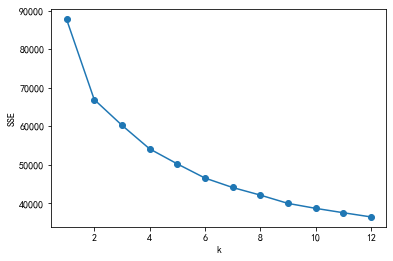

In [107]:
SSE = []  # 存放每次结果的误差平方和
for k in range(1,13):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(sentences_vec)  #聚类
    SSE.append(estimator.inertia_) # estimator.inertia_获取聚类准则的总和
X = range(1,13)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

In [108]:
cluster_num = 6
estimator = KMeans(n_clusters=cluster_num) # 构造聚类器，能过上一步骤确定聚类为4簇区分度最明显。
estimator.fit(sentences_vec) #聚类。
label_pred = estimator.labels_ #获取聚类后的簇标签。

In [109]:
cluster_df = pd.DataFrame(comments_df,columns = ['user_name','text','cut_word',])
cluster_df['cluster'] = label_pred
cluster_df.to_excel(path_dir + '\\' + 'shenghuo_comments_cluster_%d类(加词性权重).xlsx' % cluster_num)


In [110]:
#将原高维数据降为2维。
tsne = TSNE(n_components=2,init='pca',random_state=0)  #给高维数据降维，主要用于数据可视化。
X =  tsne.fit_transform(sentences_vec) #进行数据降维,降成两维

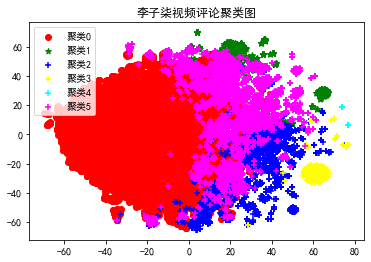

In [126]:
plt.rcParams['font.sans-serif'] = ['SimHei']  #设置字体为SimHei显示中文。
plt.rcParams['axes.unicode_minus'] = False  #设置正常显示字符。
x0 = X[label_pred == 0]  #提取X列表中所有0聚类的数据。这个还没有搞懂原理，还得再研究。
x1 = X[label_pred == 1]  #提取X列表中所有1聚类的数据。
x2 = X[label_pred == 2]  #提取X列表中所有2聚类的数据。
x3 = X[label_pred == 3]  #提取X列表中所有3聚类的数据。
x4 = X[label_pred == 4]  #提取X列表中所有4聚类的数据。
x5 = X[label_pred == 5]  #提取X列表中所有5聚类的数据。
#x6 = X[label_pred == 6]  #提取X列表中所有6聚类的数据。
#x7 = X[label_pred == 7]  #提取X列表中所有7聚类的数据。
plt.scatter(x0[:, 0], x0[:, 1], c = "red", marker='o', label='聚类0')
plt.scatter(x1[:, 0], x1[:, 1], c = "green", marker='*', label='聚类1')
plt.scatter(x2[:, 0], x2[:, 1], c = "blue", marker='+', label='聚类2')
plt.scatter(x3[:, 0], x3[:, 1], c = "yellow", marker='+', label='聚类3')
plt.scatter(x4[:, 0], x4[:, 1], c = "cyan", marker='+', label='聚类4')
plt.scatter(x5[:, 0], x5[:, 1], c = "magenta", marker='+', label='聚类5')
#plt.scatter(x6[:, 0], x6[:, 1], c = "black", marker='+', label='聚类6')
#plt.scatter(x7[:, 0], x7[:, 1], c = "red", marker='+', label='聚类7')
#plt.xlabel('petal length')  #指定x轴的标题为petal length。
#plt.ylabel('petal width')  #指定y轴的标题为petal width。
plt.title('李子柒视频评论聚类图')  #
plt.legend(loc=2)  #指定图例的位置。
#plt.savefig('cluster.png')  #保存图片至sin.png。
plt.show()

In [82]:
'''
from sklearn.cluster import DBSCAN

#进行DBSACN聚类。
db = DBSCAN(eps=2,min_samples=5).fit(sentences_vec)  #默认参数为eps=0.5,min_samples=2，eps值越小，聚类数量越多，min_samples值越大，聚类越多。
labels = db.labels_

#打印聚类个数，以调整参数。
print(len(set(labels)))

#将聚类结果存储进excel文件。
cluster_DBSCAN_df = pd.DataFrame(comments_df,columns = ['user_name','text','cut_word',])
cluster_DBSCAN_df['cluster_DBSCAN'] = labels
cluster_DBSCAN_df.to_excel(path_dir + '\\' + 'shenghuo_comments_DBSCN_cluster_%d类(加词性权重).xlsx' % len(set(labels)))
'''

In [14]:
#未进行词性加权。
'''
line_word_cut_list_have_flag = comments_df
sentences_vec = [] #关键词加权后所有单条评论的平均向量。
i = 0
while i < len(cut_word_list):
    line = cut_word_list[i]   #取cut_word_list的第i行，此时line为第i条评论。
    sentence_vec = []
    for word in line:
        for word_idf in word_tfidf[i]:
            word_vec = word_idf * model.wv[word]
        sentence_vec.append(word_vec)
    sentences_vec.append(sum(sentence_vec) / len(sentence_vec))
    if i == 10000 or i == 20000 or i == 30000:
        print(f'已处理{i}条，共{len(cut_word_list)}条。')
    i += 1
'''

#进行词性加权。
'''
#with open(path_dir + '\\' + 'all_comments_pos_word_pair_84823.json') as file_json:  #从文件中加载词性字典。
#    pos_word_dict = json.load(file_json)

flag_list = ['vn', 'vd','v','a','ad','an','d','t']  #需加权的词性列表。

sentences_vec = [] #关键词加权后所有单条评论的平均向量。
i = 0
while i < len(cut_word_list):
    line = cut_word_list[i]   #取出第i行。
    sentence_vec = []
    j = 0  #取出第j个单词。
    for word in line:  #执行第1次，则取出0位置的单词(此时j=0)，执行第2次，则取出1位置的单词（第2个，此时j=1）。
        word_vec = word_tfidf[i][j] * model.wv[word] #每个词的向量乘以此词的权重。权重：执行第1次的时候，取出第1行第1个单词的权重，执行第6次的时候，取出第1行第6个单词的权重。
        j += 1
        for k,v in pos_word_dict.items():
            if (k == word) and (v in flag_list): #遍历字典，如果字典某个键与正在处理的单词相同,此单词的词性在指定的flag_list词性列表中。
               word_vec = word_vec * 1.1 #则此单词的权重再乘以1.1。
        sentence_vec.append(word_vec)
    sentences_vec.append(sum(sentence_vec) / len(sentence_vec))
    if i == 10000 or i == 20000 or i == 30000:
        print(f'已处理{i}条，共{len(cut_word_list)}条。')
    i += 1
'''

{'生活': 0,
 '看': 1,
 '知识': 2,
 '视频': 3,
 '这就是': 4,
 '长': 5,
 '无限': 6,
 '日出而作': 7,
 '日落而息': 8,
 '田园生活': 9,
 '美好': 10,
 '生活方式': 11,
 '真正': 12,
 '这才是': 13,
 '多娇': 14,
 '赞': 15,
 '付出': 16,
 '其实': 17,
 '很多': 18,
 '看似': 19,
 '神仙': 20,
 '艰辛': 21,
 '农村': 22,
 '好': 23,
 '怀': 24,
 '干活': 25,
 '扑面而来': 26,
 '生活气息': 27,
 '太美': 28,
 '桃源': 29,
 '出来': 30,
 '拍': 31,
 '真': 32,
 '与世无争': 33,
 '向往': 34,
 '世外桃源': 35,
 '人': 36,
 '羡慕': 37,
 '般的': 38,
 '这种': 39,
 '女孩': 40,
 '诗': 41,
 '过成': 42,
 '原始': 43,
 '状态': 44,
 '越来越': 45,
 '诗意': 46,
 '创造': 47,
 '妹儿': 48,
 '巧手': 49,
 '幺': 50,
 '能干': 51,
 '总是': 52,
 '惬意': 53,
 '去': 54,
 '想': 55,
 '人间': 56,
 '平凡': 57,
 '朴素': 58,
 '努力': 59,
 '很': 60,
 '样子': 61,
 '美': 62,
 '喜欢': 63,
 '这样的生活': 64,
 '制作': 65,
 '手工': 66,
 '厉害': 67,
 '原生态': 68,
 '家里': 69,
 '真的': 70,
 '都': 71,
 '丰富': 72,
 '会': 73,
 '活着': 74,
 '中': 75,
 '关键': 76,
 '感动': 77,
 '梦': 78,
 '看着': 79,
 '好羡慕': 80,
 '梦寐以求': 81,
 '景色': 82,
 '更': 83,
 '美人美': 84,
 '食物': 85,
 '不是': 86,
 '大家': 87,
 '难道': 88,
 '不错': 89,
 '做事': 90,
 

In [15]:
'''
#提取关键词权重第二种方式： 注意，第二种和第三种差不多，只是函数不一样。
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

text_list = comments_df['cut_word'].tolist()
vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")  ##这里参数为token_pattern=r"(?u)\b\w+\b"，表示不去掉单字符。默认为token_pattern=r"(?u)\b\w\w+\b"，多了一个\w，表示从2个字符起适配，去掉单字符。
x = vectorizer.fit_transform(text_list)
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(x)

#提取关键词权重第三种方式：
from sklearn.feature_extraction.text import TfidfVectorizer

s = comments_df['cut_word'].tolist()
tfidf2 = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")  #这里参数为token_pattern=r"(?u)\b\w+\b"，表示不去掉单字符。默认为token_pattern=r"(?u)\b\w\w+\b"，多了一个\w，表示从2个字符起适配，去掉单字符。
re = tfidf2.fit_transform(s)
'''

#三种方式数据对比：第一(genism)最好，其次是第三(sklearn.TfidfVectorizer)，然后是第二（sklearn.CountVectorizer + sklearn.TfidfTransformer）
'''
看似 神仙 生活 其实 付出 很多 艰辛
[(0, 0.02354413703260787),
 (16, 0.43915344808412327),  神仙
 (17, 0.358712959732896),
 (18, 0.3215642030674232),
 (19, 0.5113637160890292),  付出
 (20, 0.30178812644516056),
 (21, 0.471107710695582)]  艰辛

(4, 17671)	0.45968595392489686  看似
(4, 15691)	0.3199103607197395
(4, 15221)	0.49269247736983146  生活
(4, 14623)	0.08949056903126384
(4, 8782)	0.3362725167502957
(4, 3142)	0.3669929721838787
(4, 2144)	0.4333920840440299  艰辛

(4, 17671)	0.45968595392489686  看似
(4, 8782)	0.3362725167502957
(4, 2144)	0.4333920840440299  生活
(4, 3142)	0.3669929721838787
(4, 15691)	0.3199103607197395
(4, 15221)	0.49269247736983146  付出
(4, 14623)	0.0894905690312638
'''

'\n看似 神仙 生活 其实 付出 很多 艰辛\n[(0, 0.02354413703260787),\n (16, 0.43915344808412327),  神仙\n (17, 0.358712959732896),\n (18, 0.3215642030674232),\n (19, 0.5113637160890292),  付出\n (20, 0.30178812644516056),\n (21, 0.471107710695582)]  艰辛\n\n(4, 17671)\t0.45968595392489686  看似\n(4, 15691)\t0.3199103607197395\n(4, 15221)\t0.49269247736983146  生活\n(4, 14623)\t0.08949056903126384\n(4, 8782)\t0.3362725167502957\n(4, 3142)\t0.3669929721838787\n(4, 2144)\t0.4333920840440299  艰辛\n\n(4, 17671)\t0.45968595392489686  看似\n(4, 8782)\t0.3362725167502957\n(4, 2144)\t0.4333920840440299  生活\n(4, 3142)\t0.3669929721838787\n(4, 15691)\t0.3199103607197395\n(4, 15221)\t0.49269247736983146  付出\n(4, 14623)\t0.0894905690312638\n'